In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
def load_animal_dataset(dataset_path, image_size=(64, 64)):
    data = []
    labels = []
    label_map = {"cat": 0, "dog": 1, "panda": 2}

    for label_name in label_map:
        folder_path = os.path.join(dataset_path, label_name)
        for file_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file_name)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Warning: Unable to read {image_path}")
                    continue
                image = cv2.resize(image, image_size)
                data.append(image.flatten())
                labels.append(label_map[label_name])
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    return np.array(data), np.array(labels)

In [52]:
# Load and split
X, y = load_animal_dataset(dataset_path="/content/drive/My Drive/CVPR/animals")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (240, 12288)
Train labels shape:  (240,)
Test data shape:  (60, 12288)
Test labels shape:  (60,)


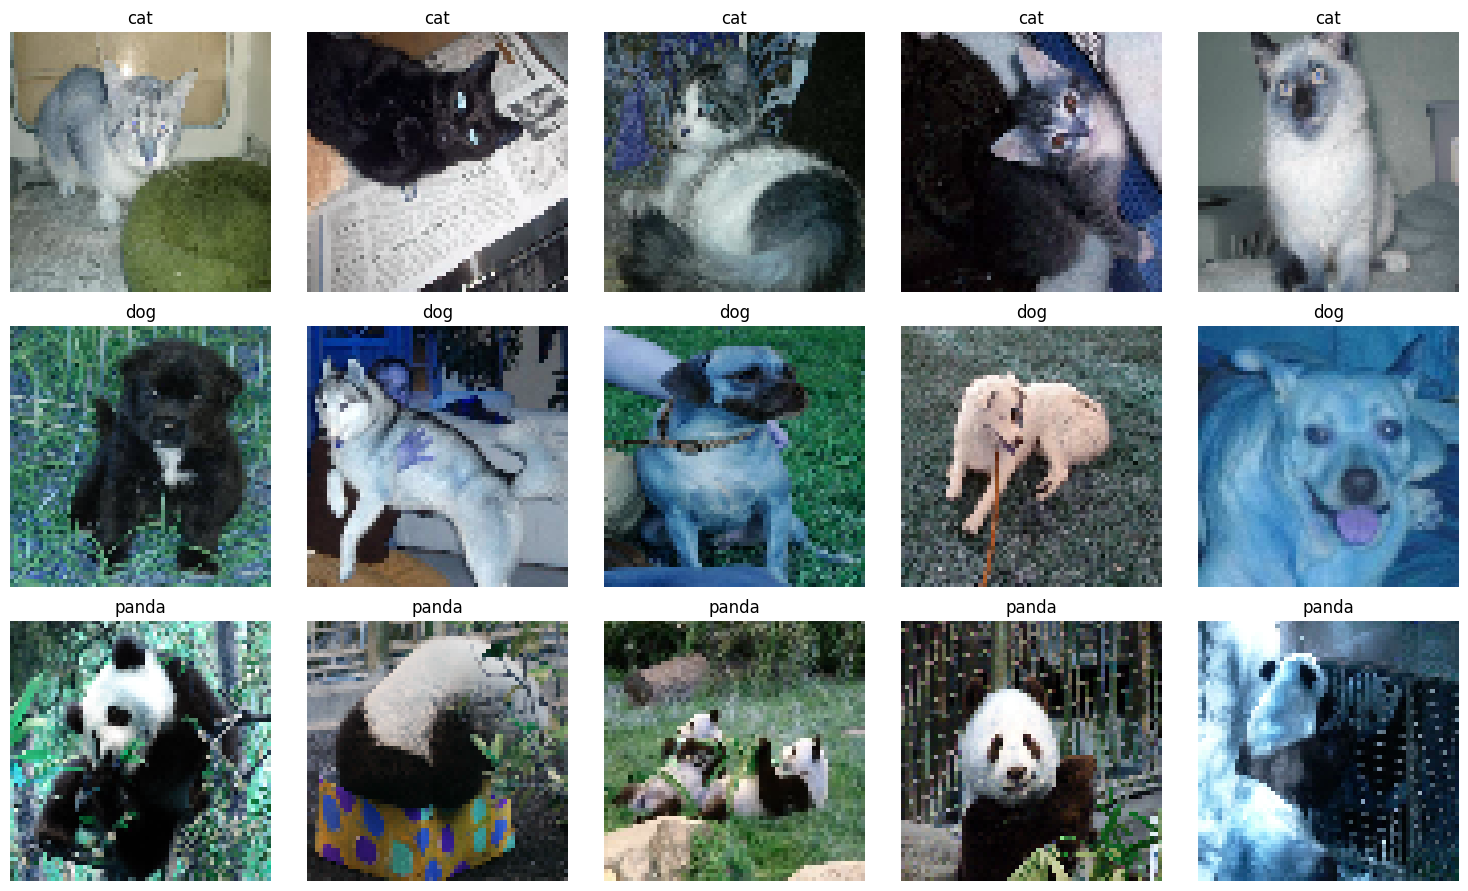

In [54]:
label_map = {0: "cat", 1: "dog", 2: "panda"}
display_counts = {0: 0, 1: 0, 2: 0}
images_to_show = 5

plt.figure(figsize=(15, 9)) # Adjust figure size for 3 rows

subplot_index_counter = {0: 1, 1: 1, 2: 1} # Counter for subplot index for each label
for i in range(len(X)):
    label = y[i]
    if display_counts[label] < images_to_show:
        image = X[i].reshape(64, 64, 3)

        subplot_row = label + 1
        subplot_col = subplot_index_counter[label]
        subplot_index = (subplot_row - 1) * images_to_show + subplot_col

        plt.subplot(len(label_map), images_to_show, subplot_index)
        plt.imshow(image)
        plt.title(label_map[label])
        plt.axis('off')
        display_counts[label] += 1
        subplot_index_counter[label] += 1

    # Stop if we have displayed enough images for all categories
    if all(count >= images_to_show for count in display_counts.values()):
        break

plt.tight_layout()
plt.show()

## Normalization

In [55]:
X_train, X_test = X_train / 255.0, X_test / 255.0

## Build KNN [Euclidean Distance]

In [56]:
class KNearestNeighbor(object):
    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def compute_distances(self, X, num_loops):
        if num_loops == 5:
            num_test = X.shape[0]
            num_train = self.X_train.shape[0]
            dists = np.zeros((num_test, num_train))

            for i in range(num_test):
                for j in range(num_train):
                    diff = X[i] - self.X_train[j]
                    dists[i, j] = np.sqrt(np.sum(diff ** 2))
            return dists

        elif num_loops == 0:
            train_squared = np.sum(np.square(self.X_train), axis=1)
            test_squared = np.sum(np.square(X), axis=1)[:, np.newaxis]
            cross_term = np.dot(X, self.X_train.T)
            dists_squared = test_squared + train_squared - 2 * cross_term
            dists = np.sqrt(np.maximum(dists_squared, 0))
            return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test, dtype=int)

        for i in range(num_test):
            nearest_idxs = np.argsort(dists[i])[:k]
            closest_y = np.array(self.y_train[nearest_idxs]).flatten().astype(int)
            counts = np.bincount(closest_y)
            y_pred[i] = np.argmax(counts)

        return y_pred

    def predict(self, X, k=1, num_loops=0):
            dists = self.compute_distances(X, num_loops=num_loops)
            return self.predict_labels(dists, k=k)

## KNN Performace Evaluation

In [57]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

# predict using loop-based distance calculation
y_test_pred = classifier.predict(X_test, k=5, num_loops=0)

# evaluate
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]

print(f'accuracy: {accuracy:.2f}')

accuracy: 0.38


## Classification Report

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.45      0.64      0.53        22
           1       0.24      0.38      0.29        16
           2       0.75      0.14      0.23        22

    accuracy                           0.38        60
   macro avg       0.48      0.38      0.35        60
weighted avg       0.50      0.38      0.36        60



## Cross Validation

In [59]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20]

# split data into 5 folds
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

k_to_accuracies = {}

for k in k_choices:
    k_to_accuracies[k] = []

    for fold in range(num_folds):
        # validation set for this fold
        X_val = X_train_folds[fold]
        y_val = y_train_folds[fold]

        # training set = all other folds
        X_train_fold = np.concatenate([X_train_folds[i] for i in range(num_folds) if i != fold])
        y_train_fold = np.concatenate([y_train_folds[i] for i in range(num_folds) if i != fold])

        # train and evaluate
        classifier = KNearestNeighbor()
        classifier.train(X_train_fold, y_train_fold)
        dists = classifier.compute_distances(X_val, num_loops=5)
        y_val_pred = classifier.predict_labels(dists, k=k)

        acc = np.mean(y_val_pred == y_val)
        k_to_accuracies[k].append(acc)

In [60]:
# Average accuracy for each k
for k in k_choices:
    accs = k_to_accuracies[k]
    accs_formatted = [f"{acc:.4f}" for acc in accs]
    avg_acc = np.mean(accs)
    print(f"k = {k}, accuracies = {accs_formatted}, mean accuracy = {avg_acc:.4f}")

# Find k with highest average accuracy
best_k = max(k_to_accuracies, key=lambda k: np.mean(k_to_accuracies[k]))
print(f'\nBest k based on cross-validation: {best_k}')

k = 1, accuracies = ['0.4375', '0.3542', '0.4583', '0.1875', '0.3333'], mean accuracy = 0.3542
k = 3, accuracies = ['0.3125', '0.3542', '0.3958', '0.2917', '0.3333'], mean accuracy = 0.3375
k = 5, accuracies = ['0.3333', '0.4167', '0.4792', '0.2917', '0.3542'], mean accuracy = 0.3750
k = 8, accuracies = ['0.3125', '0.3125', '0.3333', '0.2917', '0.4583'], mean accuracy = 0.3417
k = 10, accuracies = ['0.3333', '0.3125', '0.3750', '0.2500', '0.4375'], mean accuracy = 0.3417
k = 12, accuracies = ['0.3542', '0.3750', '0.3750', '0.2708', '0.3958'], mean accuracy = 0.3542
k = 15, accuracies = ['0.3750', '0.3750', '0.3542', '0.2708', '0.4167'], mean accuracy = 0.3583
k = 20, accuracies = ['0.3542', '0.4167', '0.3125', '0.2708', '0.4583'], mean accuracy = 0.3625

Best k based on cross-validation: 5


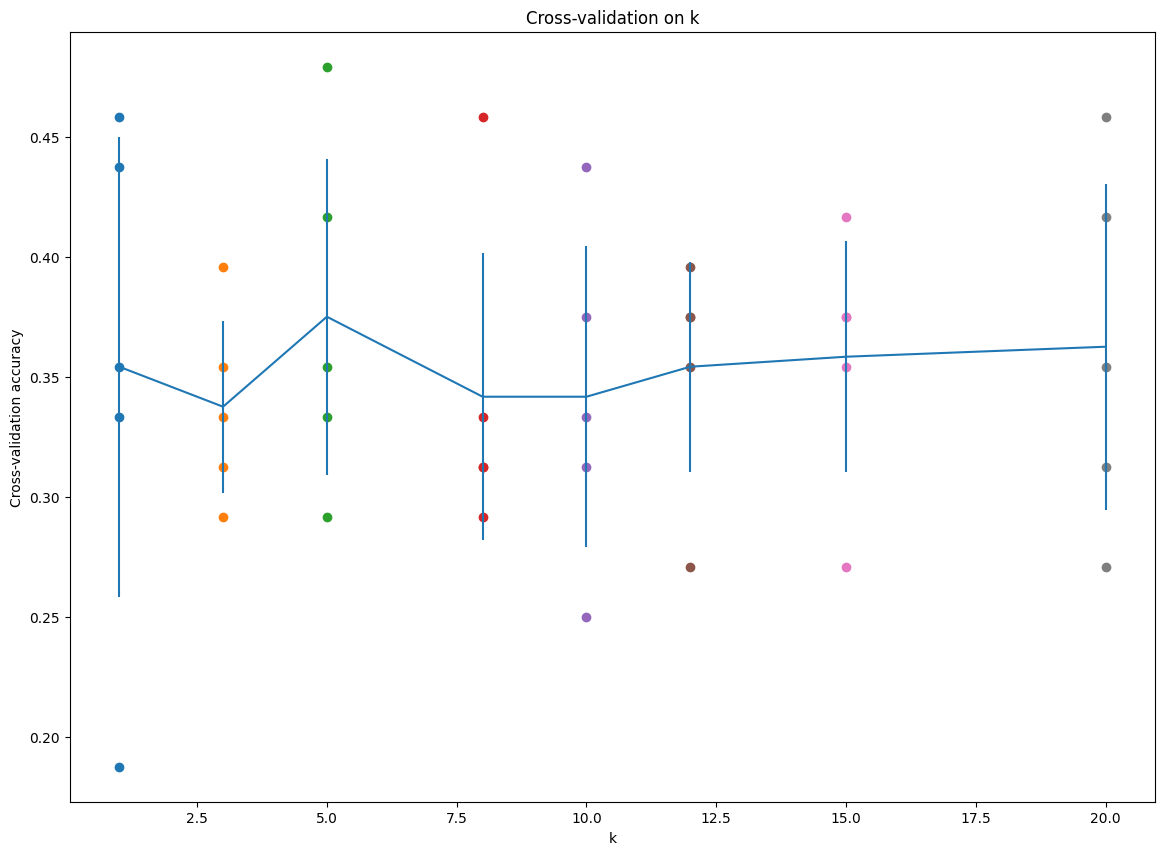

In [61]:
plt.figure(figsize=(14, 10))
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()